In [1]:
trial_number_ml = "005"
random_state_init = 555

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model1_rna_b_rna_n
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model1_rna_b_rna_n


In [4]:
def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model1_files = ['../../data_for_ml/ml_datasets_set2/model1_rna_bin_non_rna_bin/data.pkl']

# Load datasets
model1_df = load_and_concatenate_datasets(model1_files)

# Preprocess datasets
X1, y1 = preprocess_data(model1_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X1, y1)

# Output shapes
print(f"Model 1 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 1 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 16:17:13,659] A new study created in memory with name: no-name-657a981b-cead-4045-ba8b-06d5a3056641


[I 2024-05-01 16:18:07,317] Trial 0 finished with value: 0.6228781275713894 and parameters: {'n_estimators': 198, 'max_depth': 64, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6228781275713894.


[I 2024-05-01 16:19:27,745] Trial 2 finished with value: 0.621605258078607 and parameters: {'n_estimators': 787, 'max_depth': 90, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 0 with value: 0.6228781275713894.


[I 2024-05-01 16:19:47,615] Trial 3 finished with value: 0.6225571165899695 and parameters: {'n_estimators': 897, 'max_depth': 36, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.6228781275713894.


[I 2024-05-01 16:20:04,202] Trial 4 finished with value: 0.6270233342476051 and parameters: {'n_estimators': 482, 'max_depth': 91, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.6270233342476051.


[I 2024-05-01 16:20:51,527] Trial 1 finished with value: 0.6254274220583305 and parameters: {'n_estimators': 951, 'max_depth': 52, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.6270233342476051.


[I 2024-05-01 16:21:07,159] Trial 7 pruned. 


[I 2024-05-01 16:21:12,626] Trial 6 finished with value: 0.6184139416288259 and parameters: {'n_estimators': 596, 'max_depth': 79, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 4 with value: 0.6270233342476051.


[I 2024-05-01 16:21:26,336] Trial 5 finished with value: 0.622553561088593 and parameters: {'n_estimators': 641, 'max_depth': 71, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 4 with value: 0.6270233342476051.


[I 2024-05-01 16:21:37,964] Trial 11 pruned. 


[I 2024-05-01 16:21:42,072] Trial 12 pruned. 


[I 2024-05-01 16:21:47,404] Trial 9 pruned. 


[I 2024-05-01 16:22:37,524] Trial 8 finished with value: 0.6231950751226648 and parameters: {'n_estimators': 873, 'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 4 with value: 0.6270233342476051.


[I 2024-05-01 16:22:52,844] Trial 15 pruned. 


[I 2024-05-01 16:22:56,222] Trial 14 finished with value: 0.6308460061560967 and parameters: {'n_estimators': 366, 'max_depth': 44, 'min_samples_split': 19, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.6308460061560967.


[I 2024-05-01 16:22:57,166] Trial 13 finished with value: 0.6273423135139529 and parameters: {'n_estimators': 401, 'max_depth': 95, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.6308460061560967.


[I 2024-05-01 16:22:58,442] Trial 10 finished with value: 0.6244704842592875 and parameters: {'n_estimators': 702, 'max_depth': 19, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 14 with value: 0.6308460061560967.


[I 2024-05-01 16:23:09,827] Trial 18 pruned. 


[I 2024-05-01 16:23:13,661] Trial 17 pruned. 


[I 2024-05-01 16:23:23,437] Trial 19 pruned. 


[I 2024-05-01 16:23:30,388] Trial 20 pruned. 


[I 2024-05-01 16:23:44,727] Trial 22 pruned. 


[I 2024-05-01 16:24:03,077] Trial 24 pruned. 


[I 2024-05-01 16:24:06,225] Trial 21 finished with value: 0.6251074269344467 and parameters: {'n_estimators': 253, 'max_depth': 59, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.6308460061560967.


[I 2024-05-01 16:24:11,728] Trial 23 finished with value: 0.6267033391237212 and parameters: {'n_estimators': 201, 'max_depth': 61, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.6308460061560967.


[I 2024-05-01 16:24:21,520] Trial 16 finished with value: 0.6286156909355032 and parameters: {'n_estimators': 431, 'max_depth': 52, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.6308460061560967.


[I 2024-05-01 16:24:38,265] Trial 28 pruned. 


[I 2024-05-01 16:24:47,990] Trial 25 finished with value: 0.6308480378711689 and parameters: {'n_estimators': 219, 'max_depth': 87, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 25 with value: 0.6308480378711689.


[I 2024-05-01 16:24:52,373] Trial 30 pruned. 


[I 2024-05-01 16:25:02,400] Trial 31 pruned. 


[I 2024-05-01 16:25:20,126] Trial 26 finished with value: 0.6337168195532258 and parameters: {'n_estimators': 363, 'max_depth': 83, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.6337168195532258.


[I 2024-05-01 16:25:32,498] Trial 33 pruned. 


[I 2024-05-01 16:25:34,294] Trial 27 finished with value: 0.6282956958116194 and parameters: {'n_estimators': 378, 'max_depth': 87, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.6337168195532258.


[I 2024-05-01 16:25:59,836] Trial 32 finished with value: 0.6305290586048212 and parameters: {'n_estimators': 287, 'max_depth': 70, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.6337168195532258.


[I 2024-05-01 16:26:05,382] Trial 34 finished with value: 0.6340357988195736 and parameters: {'n_estimators': 160, 'max_depth': 72, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 34 with value: 0.6340357988195736.


[I 2024-05-01 16:26:06,141] Trial 36 pruned. 


[I 2024-05-01 16:26:07,729] Trial 35 finished with value: 0.6295741525208505 and parameters: {'n_estimators': 164, 'max_depth': 71, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 34 with value: 0.6340357988195736.


[I 2024-05-01 16:26:12,328] Trial 37 pruned. 


[I 2024-05-01 16:26:14,236] Trial 38 pruned. 


[I 2024-05-01 16:26:17,383] Trial 39 pruned. 


[I 2024-05-01 16:26:20,712] Trial 40 pruned. 


[I 2024-05-01 16:26:24,543] Trial 29 finished with value: 0.6279782403315759 and parameters: {'n_estimators': 576, 'max_depth': 31, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 34 with value: 0.6340357988195736.


[I 2024-05-01 16:26:39,917] Trial 44 pruned. 


[I 2024-05-01 16:26:41,247] Trial 43 pruned. 


[I 2024-05-01 16:26:44,045] Trial 42 pruned. 


[I 2024-05-01 16:26:52,765] Trial 45 pruned. 


[I 2024-05-01 16:27:00,221] Trial 47 pruned. 


[I 2024-05-01 16:27:00,647] Trial 46 pruned. 


[I 2024-05-01 16:27:05,220] Trial 48 pruned. 


[I 2024-05-01 16:27:26,822] Trial 49 pruned. 


[I 2024-05-01 16:27:38,624] Trial 41 finished with value: 0.6276597689939963 and parameters: {'n_estimators': 993, 'max_depth': 65, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 34 with value: 0.6340357988195736.


Best trial for RandomForestClassifier:
  Value: 0.6340357988195736
  Params: 
    n_estimators: 160
    max_depth: 72
    min_samples_split: 7
    min_samples_leaf: 4
    max_features: sqrt

Best hyperparameters for RandomForestClassifier: {'n_estimators': 160, 'max_depth': 72, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt'}


[I 2024-05-01 16:27:43,187] A new study created in memory with name: no-name-bb701aff-40dc-4b5c-a66d-14f8d9752022


RandomForestClassifier accuracy: 0.6204



[I 2024-05-01 16:27:49,724] Trial 1 finished with value: 0.6228786355001574 and parameters: {'n_estimators': 139, 'max_depth': 10, 'learning_rate': 0.10042576438296412, 'min_child_weight': 1, 'subsample': 0.9568060324458544, 'colsample_bytree': 0.8248417804817558, 'gamma': 4.234292914841935, 'reg_lambda': 2.677869285071005, 'reg_alpha': 0.4326276424359669}. Best is trial 1 with value: 0.6228786355001574.


[I 2024-05-01 16:27:56,157] Trial 3 finished with value: 0.6110824977905098 and parameters: {'n_estimators': 431, 'max_depth': 3, 'learning_rate': 0.1117764736957368, 'min_child_weight': 7, 'subsample': 0.7134789945788598, 'colsample_bytree': 0.920077469515847, 'gamma': 0.20415804714221886, 'reg_lambda': 0.16712116125998225, 'reg_alpha': 0.03187288744105625}. Best is trial 1 with value: 0.6228786355001574.


[I 2024-05-01 16:28:02,146] Trial 5 finished with value: 0.6145892380052621 and parameters: {'n_estimators': 113, 'max_depth': 4, 'learning_rate': 0.06890865488828847, 'min_child_weight': 7, 'subsample': 0.5562411325373426, 'colsample_bytree': 0.9036770524144154, 'gamma': 1.545681481059051, 'reg_lambda': 0.11748104370754159, 'reg_alpha': 0.016550369505084535}. Best is trial 1 with value: 0.6228786355001574.


[I 2024-05-01 16:28:02,524] Trial 0 finished with value: 0.6117235038958136 and parameters: {'n_estimators': 293, 'max_depth': 7, 'learning_rate': 0.17302260629295957, 'min_child_weight': 8, 'subsample': 0.8620178511388554, 'colsample_bytree': 0.5840004745464634, 'gamma': 0.38605013095471596, 'reg_lambda': 0.5187003608723062, 'reg_alpha': 0.4811768691400758}. Best is trial 1 with value: 0.6228786355001574.


[I 2024-05-01 16:28:08,711] Trial 7 finished with value: 0.6158682026432614 and parameters: {'n_estimators': 105, 'max_depth': 3, 'learning_rate': 0.24108126392025195, 'min_child_weight': 3, 'subsample': 0.6647947272822486, 'colsample_bytree': 0.6265792712949229, 'gamma': 4.381935304649977, 'reg_lambda': 0.9954442850140767, 'reg_alpha': 5.906636292272968}. Best is trial 1 with value: 0.6228786355001574.


[I 2024-05-01 16:28:14,514] Trial 2 finished with value: 0.6040771442212944 and parameters: {'n_estimators': 758, 'max_depth': 7, 'learning_rate': 0.19339120690970465, 'min_child_weight': 9, 'subsample': 0.5403642172207959, 'colsample_bytree': 0.8429144290827122, 'gamma': 4.585678198098958, 'reg_lambda': 0.016411969155237953, 'reg_alpha': 0.03940579036166298}. Best is trial 1 with value: 0.6228786355001574.


[I 2024-05-01 16:28:17,228] Trial 9 pruned. 


[I 2024-05-01 16:28:17,654] Trial 6 pruned. 


[I 2024-05-01 16:28:21,431] Trial 11 pruned. 


[I 2024-05-01 16:28:24,065] Trial 4 finished with value: 0.617464622761304 and parameters: {'n_estimators': 536, 'max_depth': 9, 'learning_rate': 0.10593292089984377, 'min_child_weight': 4, 'subsample': 0.7871191514013083, 'colsample_bytree': 0.5570293426415756, 'gamma': 0.22780336596773643, 'reg_lambda': 1.8021594567159023, 'reg_alpha': 0.6573557221234938}. Best is trial 1 with value: 0.6228786355001574.


[I 2024-05-01 16:28:24,468] Trial 8 finished with value: 0.6168195532258556 and parameters: {'n_estimators': 220, 'max_depth': 8, 'learning_rate': 0.17656619235506163, 'min_child_weight': 4, 'subsample': 0.656009756416436, 'colsample_bytree': 0.7509434396594867, 'gamma': 2.172353968447859, 'reg_lambda': 0.9557119031230586, 'reg_alpha': 0.06483514927890541}. Best is trial 1 with value: 0.6228786355001574.


[I 2024-05-01 16:28:25,060] Trial 12 pruned. 


[I 2024-05-01 16:28:28,863] Trial 13 pruned. 


[I 2024-05-01 16:28:29,158] Trial 14 pruned. 


[I 2024-05-01 16:28:42,833] Trial 17 finished with value: 0.6247914952407074 and parameters: {'n_estimators': 143, 'max_depth': 9, 'learning_rate': 0.10399328147129301, 'min_child_weight': 3, 'subsample': 0.784225567939494, 'colsample_bytree': 0.783880297216672, 'gamma': 1.3100577145042465, 'reg_lambda': 3.081940644089367, 'reg_alpha': 1.0344289288516495}. Best is trial 17 with value: 0.6247914952407074.


[I 2024-05-01 16:28:47,654] Trial 10 finished with value: 0.6158692185007975 and parameters: {'n_estimators': 575, 'max_depth': 5, 'learning_rate': 0.06767744586244953, 'min_child_weight': 9, 'subsample': 0.7360185948268202, 'colsample_bytree': 0.6957655075918792, 'gamma': 3.2680405610492174, 'reg_lambda': 2.038531505042917, 'reg_alpha': 0.021194815509130802}. Best is trial 17 with value: 0.6247914952407074.


[I 2024-05-01 16:28:50,960] Trial 19 pruned. 


[I 2024-05-01 16:28:53,019] Trial 18 finished with value: 0.6270253659626774 and parameters: {'n_estimators': 139, 'max_depth': 9, 'learning_rate': 0.11560416307166678, 'min_child_weight': 2, 'subsample': 0.8828872971782408, 'colsample_bytree': 0.7474177506858358, 'gamma': 1.3639832155474099, 'reg_lambda': 4.059585668125138, 'reg_alpha': 1.3031587476190738}. Best is trial 18 with value: 0.6270253659626774.


[I 2024-05-01 16:28:53,834] Trial 20 pruned. 


[I 2024-05-01 16:28:56,449] Trial 22 pruned. 


[I 2024-05-01 16:29:02,675] Trial 16 finished with value: 0.6206493361371002 and parameters: {'n_estimators': 975, 'max_depth': 10, 'learning_rate': 0.10506891957956332, 'min_child_weight': 1, 'subsample': 0.9880245799289017, 'colsample_bytree': 0.7325915632723629, 'gamma': 3.535052884100583, 'reg_lambda': 7.540449706949201, 'reg_alpha': 0.6033641633845137}. Best is trial 18 with value: 0.6270253659626774.


[I 2024-05-01 16:29:05,826] Trial 21 finished with value: 0.6203268013693759 and parameters: {'n_estimators': 225, 'max_depth': 8, 'learning_rate': 0.204760712310211, 'min_child_weight': 3, 'subsample': 0.8558522718693878, 'colsample_bytree': 0.7363728722628942, 'gamma': 1.104724344022023, 'reg_lambda': 5.246923377665686, 'reg_alpha': 2.230337258371568}. Best is trial 18 with value: 0.6270253659626774.


[I 2024-05-01 16:29:11,939] Trial 15 finished with value: 0.6235191336766931 and parameters: {'n_estimators': 995, 'max_depth': 10, 'learning_rate': 0.01566364248843871, 'min_child_weight': 1, 'subsample': 0.9814332479992267, 'colsample_bytree': 0.7082122411968391, 'gamma': 3.594729555445553, 'reg_lambda': 5.823331676980471, 'reg_alpha': 0.8426880688619496}. Best is trial 18 with value: 0.6270253659626774.


[I 2024-05-01 16:29:13,465] Trial 24 finished with value: 0.6203278172269121 and parameters: {'n_estimators': 135, 'max_depth': 9, 'learning_rate': 0.1367233841894265, 'min_child_weight': 2, 'subsample': 0.887040812698339, 'colsample_bytree': 0.8580605826641605, 'gamma': 2.1002787464049284, 'reg_lambda': 4.451241072377975, 'reg_alpha': 0.1903077097628004}. Best is trial 18 with value: 0.6270253659626774.


[I 2024-05-01 16:29:15,614] Trial 25 finished with value: 0.616500573959508 and parameters: {'n_estimators': 137, 'max_depth': 9, 'learning_rate': 0.13771135060614187, 'min_child_weight': 2, 'subsample': 0.7914190857373667, 'colsample_bytree': 0.8493076251900419, 'gamma': 2.176333877631045, 'reg_lambda': 1.0859880257976362, 'reg_alpha': 0.23210013634353782}. Best is trial 18 with value: 0.6270253659626774.


[I 2024-05-01 16:29:16,395] Trial 26 pruned. 


[I 2024-05-01 16:29:19,745] Trial 29 pruned. 


[I 2024-05-01 16:29:21,289] Trial 30 pruned. 


[I 2024-05-01 16:29:30,100] Trial 31 pruned. 


[I 2024-05-01 16:29:30,970] Trial 27 finished with value: 0.6267058787675616 and parameters: {'n_estimators': 347, 'max_depth': 6, 'learning_rate': 0.014101144335976687, 'min_child_weight': 4, 'subsample': 0.7942149532849415, 'colsample_bytree': 0.6363135535012168, 'gamma': 2.721747725010708, 'reg_lambda': 1.225454921446753, 'reg_alpha': 0.9701874097074017}. Best is trial 18 with value: 0.6270253659626774.


[I 2024-05-01 16:29:32,283] Trial 32 pruned. 


[I 2024-05-01 16:29:33,402] Trial 33 pruned. 


[I 2024-05-01 16:29:35,242] Trial 28 finished with value: 0.6267074025538658 and parameters: {'n_estimators': 375, 'max_depth': 6, 'learning_rate': 0.017269018674902964, 'min_child_weight': 4, 'subsample': 0.9496805146358962, 'colsample_bytree': 0.6490326383845805, 'gamma': 2.79828051967465, 'reg_lambda': 1.593329837349827, 'reg_alpha': 0.8612978707262694}. Best is trial 18 with value: 0.6270253659626774.


[I 2024-05-01 16:29:36,798] Trial 34 pruned. 


[I 2024-05-01 16:29:38,059] Trial 35 pruned. 


[I 2024-05-01 16:29:40,816] Trial 38 pruned. 


[I 2024-05-01 16:29:41,637] Trial 23 finished with value: 0.6270228263188371 and parameters: {'n_estimators': 991, 'max_depth': 6, 'learning_rate': 0.12578871695341395, 'min_child_weight': 3, 'subsample': 0.7829687037699085, 'colsample_bytree': 0.6683624172261892, 'gamma': 2.064438500085227, 'reg_lambda': 5.505168429519484, 'reg_alpha': 0.9833101776466099}. Best is trial 18 with value: 0.6270253659626774.


[I 2024-05-01 16:29:42,263] Trial 39 pruned. 


[I 2024-05-01 16:29:44,033] Trial 36 pruned. 


[I 2024-05-01 16:29:46,504] Trial 40 pruned. 


[I 2024-05-01 16:29:49,016] Trial 41 pruned. 


[I 2024-05-01 16:29:50,330] Trial 44 pruned. 


[I 2024-05-01 16:29:50,627] Trial 42 pruned. 


[I 2024-05-01 16:29:56,328] Trial 43 pruned. 


[I 2024-05-01 16:29:56,570] Trial 46 pruned. 


[I 2024-05-01 16:29:57,974] Trial 37 finished with value: 0.6231976147665051 and parameters: {'n_estimators': 389, 'max_depth': 5, 'learning_rate': 0.03123089407432339, 'min_child_weight': 6, 'subsample': 0.8232393704956023, 'colsample_bytree': 0.529602096072739, 'gamma': 2.6879648170137243, 'reg_lambda': 2.6877224025782396, 'reg_alpha': 1.5074045477272873}. Best is trial 18 with value: 0.6270253659626774.


[I 2024-05-01 16:29:58,543] Trial 48 pruned. 


[I 2024-05-01 16:29:59,529] Trial 49 pruned. 


[I 2024-05-01 16:29:59,664] Trial 45 finished with value: 0.627022826318837 and parameters: {'n_estimators': 201, 'max_depth': 6, 'learning_rate': 0.09863932033720309, 'min_child_weight': 4, 'subsample': 0.7212833429274274, 'colsample_bytree': 0.7163984222830438, 'gamma': 1.5064280666655865, 'reg_lambda': 0.7267955427854423, 'reg_alpha': 1.111196161992532}. Best is trial 18 with value: 0.6270253659626774.


[I 2024-05-01 16:30:02,825] Trial 47 finished with value: 0.6196888428366806 and parameters: {'n_estimators': 338, 'max_depth': 5, 'learning_rate': 0.09893809748901472, 'min_child_weight': 4, 'subsample': 0.8043634041106082, 'colsample_bytree': 0.7213329462655802, 'gamma': 3.0398013813444016, 'reg_lambda': 0.7717802217600592, 'reg_alpha': 1.1296392268627113}. Best is trial 18 with value: 0.6270253659626774.


Best trial for XGBClassifier:
  Value: 0.6270253659626774
  Params: 
    n_estimators: 139
    max_depth: 9
    learning_rate: 0.11560416307166678
    min_child_weight: 2
    subsample: 0.8828872971782408
    colsample_bytree: 0.7474177506858358
    gamma: 1.3639832155474099
    reg_lambda: 4.059585668125138
    reg_alpha: 1.3031587476190738

Best hyperparameters for XGBClassifier: {'n_estimators': 139, 'max_depth': 9, 'learning_rate': 0.11560416307166678, 'min_child_weight': 2, 'subsample': 0.8828872971782408, 'colsample_bytree': 0.7474177506858358, 'gamma': 1.3639832155474099, 'reg_lambda': 4.059585668125138, 'reg_alpha': 1.3031587476190738}


[I 2024-05-01 16:30:50,192] A new study created in memory with name: no-name-d832d8e8-3c00-4bc7-bbd7-a34cc7f14d44


XGBClassifier accuracy: 0.6166



[I 2024-05-01 16:30:50,913] Trial 3 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 48, 'max_depth': 9, 'learning_rate': 0.13380043562292748, 'n_estimators': 391, 'min_child_weight': 0.025834966056177872, 'min_child_samples': 1940, 'subsample': 0.8745951064851699, 'colsample_bytree': 0.8894599418331693, 'reg_alpha': 4.6157729282792514e-09, 'reg_lambda': 6.4282923937309934e-06}. Best is trial 3 with value: 0.4995215311004785.


[I 2024-05-01 16:30:51,281] Trial 0 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'max_depth': 9, 'learning_rate': 0.39867253644211315, 'n_estimators': 908, 'min_child_weight': 0.009432503774111272, 'min_child_samples': 1768, 'subsample': 0.8757272488542756, 'colsample_bytree': 0.816064706572848, 'reg_alpha': 0.5379314833617383, 'reg_lambda': 3.0460602516645784e-08}. Best is trial 3 with value: 0.4995215311004785.


[I 2024-05-01 16:30:51,418] Trial 4 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 71, 'max_depth': 8, 'learning_rate': 0.21803600281038316, 'n_estimators': 115, 'min_child_weight': 0.0054136021199667995, 'min_child_samples': 1444, 'subsample': 0.8533056292460572, 'colsample_bytree': 0.9459731814878227, 'reg_alpha': 0.46212809499162966, 'reg_lambda': 0.00013540409587002505}. Best is trial 3 with value: 0.4995215311004785.


[I 2024-05-01 16:30:53,944] Trial 6 finished with value: 0.5734790073040157 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'max_depth': 2, 'learning_rate': 0.09977304032867704, 'n_estimators': 734, 'min_child_weight': 0.01611813278526455, 'min_child_samples': 876, 'subsample': 0.8317706175717094, 'colsample_bytree': 0.9962697468774644, 'reg_alpha': 0.0007727898852724585, 'reg_lambda': 4.8825475319680205e-09}. Best is trial 6 with value: 0.5734790073040157.


[I 2024-05-01 16:30:55,865] Trial 1 finished with value: 0.6005754832942228 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': 13, 'learning_rate': 0.2348058201967306, 'n_estimators': 638, 'min_child_weight': 0.00782600659315663, 'min_child_samples': 263, 'subsample': 0.919978229383439, 'colsample_bytree': 0.8631064256495596, 'reg_alpha': 0.005460577474487812, 'reg_lambda': 3.6789433768871756e-05}. Best is trial 1 with value: 0.6005754832942228.


[I 2024-05-01 16:30:56,337] Trial 8 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 94, 'max_depth': 7, 'learning_rate': 0.1496817651959705, 'n_estimators': 157, 'min_child_weight': 0.0015751115102354547, 'min_child_samples': 1850, 'subsample': 0.824987079922898, 'colsample_bytree': 0.8183738445670046, 'reg_alpha': 5.960061443440839e-07, 'reg_lambda': 6.5277293939011034e-09}. Best is trial 1 with value: 0.6005754832942228.


[I 2024-05-01 16:30:56,766] Trial 5 finished with value: 0.5916394924775749 and parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'max_depth': 12, 'learning_rate': 0.4703807449643773, 'n_estimators': 348, 'min_child_weight': 0.021696039364263623, 'min_child_samples': 654, 'subsample': 0.9192014231259198, 'colsample_bytree': 0.9511091496626514, 'reg_alpha': 0.08665352443648915, 'reg_lambda': 1.3626404227441719e-08}. Best is trial 1 with value: 0.6005754832942228.


[I 2024-05-01 16:30:56,857] Trial 9 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 77, 'max_depth': 0, 'learning_rate': 0.030802358796014166, 'n_estimators': 124, 'min_child_weight': 0.016006420096920073, 'min_child_samples': 1684, 'subsample': 0.9409766162754557, 'colsample_bytree': 0.8813768316063503, 'reg_alpha': 2.2764911438208022e-09, 'reg_lambda': 0.00025038833318336733}. Best is trial 1 with value: 0.6005754832942228.


[I 2024-05-01 16:30:59,116] Trial 11 finished with value: 0.5390460081878118 and parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'max_depth': 1, 'learning_rate': 0.07007259571567885, 'n_estimators': 208, 'min_child_weight': 0.05707083036523393, 'min_child_samples': 1147, 'subsample': 0.9003048141192019, 'colsample_bytree': 0.833412041385689, 'reg_alpha': 1.3757934613679855e-05, 'reg_lambda': 0.0020406836614103724}. Best is trial 1 with value: 0.6005754832942228.


[I 2024-05-01 16:30:59,629] Trial 12 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': 5, 'learning_rate': 0.3280213429223496, 'n_estimators': 112, 'min_child_weight': 0.03564970029488555, 'min_child_samples': 1998, 'subsample': 0.9208794671947187, 'colsample_bytree': 0.9406415177487943, 'reg_alpha': 5.59732875221861e-10, 'reg_lambda': 2.849794386971114e-07}. Best is trial 1 with value: 0.6005754832942228.


[I 2024-05-01 16:31:06,159] Trial 10 finished with value: 0.5782576011540141 and parameters: {'boosting_type': 'goss', 'num_leaves': 38, 'max_depth': 15, 'learning_rate': 0.32394111193808556, 'n_estimators': 680, 'min_child_weight': 0.07031513326982389, 'min_child_samples': 142, 'subsample': 0.9063433584234968, 'colsample_bytree': 0.8419508849994879, 'reg_alpha': 0.286323412020831, 'reg_lambda': 1.924899461552921e-08}. Best is trial 1 with value: 0.6005754832942228.


[I 2024-05-01 16:31:06,975] Trial 13 finished with value: 0.5760201749306678 and parameters: {'boosting_type': 'goss', 'num_leaves': 50, 'max_depth': 15, 'learning_rate': 0.2676713699783195, 'n_estimators': 625, 'min_child_weight': 0.0025631351697199367, 'min_child_samples': 196, 'subsample': 0.9945631697756255, 'colsample_bytree': 0.8549833906331463, 'reg_alpha': 0.0012583587576519364, 'reg_lambda': 0.45925113134065104}. Best is trial 1 with value: 0.6005754832942228.


[I 2024-05-01 16:31:09,629] Trial 15 finished with value: 0.5871768303213157 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'max_depth': 12, 'learning_rate': 0.4989628882753214, 'n_estimators': 437, 'min_child_weight': 0.004658764955645895, 'min_child_samples': 500, 'subsample': 0.9570271071150992, 'colsample_bytree': 0.9296568231591956, 'reg_alpha': 0.0027716641503124162, 'reg_lambda': 1.4635687738952444e-10}. Best is trial 1 with value: 0.6005754832942228.


[I 2024-05-01 16:31:09,945] Trial 14 finished with value: 0.5757088145958411 and parameters: {'boosting_type': 'goss', 'num_leaves': 32, 'max_depth': 14, 'learning_rate': 0.4989634981656513, 'n_estimators': 436, 'min_child_weight': 0.00399898027483196, 'min_child_samples': 287, 'subsample': 0.9826802268341484, 'colsample_bytree': 0.9355518810421519, 'reg_alpha': 0.0037838116524702347, 'reg_lambda': 0.1498371038347502}. Best is trial 1 with value: 0.6005754832942228.


[I 2024-05-01 16:31:10,070] Trial 7 finished with value: 0.5967401131665294 and parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'max_depth': 3, 'learning_rate': 0.2946990820542301, 'n_estimators': 618, 'min_child_weight': 0.0075282753688674835, 'min_child_samples': 433, 'subsample': 0.8932406937776677, 'colsample_bytree': 0.8428466641371539, 'reg_alpha': 8.82937787038409e-07, 'reg_lambda': 0.014323048554498985}. Best is trial 1 with value: 0.6005754832942228.


[I 2024-05-01 16:31:11,790] Trial 17 finished with value: 0.5862259876674896 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': 11, 'learning_rate': 0.4044726368592056, 'n_estimators': 327, 'min_child_weight': 0.01013632784806104, 'min_child_samples': 628, 'subsample': 0.9384002479626926, 'colsample_bytree': 0.9829650236899785, 'reg_alpha': 0.022166827164014406, 'reg_lambda': 9.301671086074814e-07}. Best is trial 1 with value: 0.6005754832942228.


[I 2024-05-01 16:31:12,057] Trial 16 finished with value: 0.589727140665793 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 12, 'learning_rate': 0.49710360882851656, 'n_estimators': 443, 'min_child_weight': 0.00745795428897015, 'min_child_samples': 566, 'subsample': 0.961978411886311, 'colsample_bytree': 0.9795407635848635, 'reg_alpha': 0.014088051647441306, 'reg_lambda': 3.105456629342177e-06}. Best is trial 1 with value: 0.6005754832942228.


[I 2024-05-01 16:31:12,603] Trial 2 finished with value: 0.585272605369823 and parameters: {'boosting_type': 'goss', 'num_leaves': 97, 'max_depth': 1, 'learning_rate': 0.341886885488753, 'n_estimators': 989, 'min_child_weight': 0.0023869563602865683, 'min_child_samples': 43, 'subsample': 0.826925196396183, 'colsample_bytree': 0.8095264156075459, 'reg_alpha': 0.020906821755587394, 'reg_lambda': 1.5625927935765399e-09}. Best is trial 1 with value: 0.6005754832942228.


[I 2024-05-01 16:31:13,744] Trial 21 pruned. 


[I 2024-05-01 16:31:14,327] Trial 18 finished with value: 0.5913230528550676 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': 3, 'learning_rate': 0.21254255421980914, 'n_estimators': 836, 'min_child_weight': 0.008466888292593282, 'min_child_samples': 541, 'subsample': 0.8017713285423277, 'colsample_bytree': 0.8762482853207996, 'reg_alpha': 5.539908986403055e-07, 'reg_lambda': 0.0343322615520855}. Best is trial 1 with value: 0.6005754832942228.


[I 2024-05-01 16:31:16,178] Trial 19 finished with value: 0.5919574558863865 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': 4, 'learning_rate': 0.2124930257353438, 'n_estimators': 826, 'min_child_weight': 0.0011744858744595966, 'min_child_samples': 438, 'subsample': 0.8033271217653482, 'colsample_bytree': 0.8681544608517668, 'reg_alpha': 1.3003334208589128e-05, 'reg_lambda': 0.011301685194185038}. Best is trial 1 with value: 0.6005754832942228.


[I 2024-05-01 16:31:16,506] Trial 20 pruned. 


[I 2024-05-01 16:31:21,873] Trial 25 finished with value: 0.5992939790123832 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'max_depth': 6, 'learning_rate': 0.17127287130004337, 'n_estimators': 557, 'min_child_weight': 0.002668380676662631, 'min_child_samples': 370, 'subsample': 0.8021807950806235, 'colsample_bytree': 0.9157485152118153, 'reg_alpha': 0.00010165165952193859, 'reg_lambda': 0.00019976716554486823}. Best is trial 1 with value: 0.6005754832942228.


[I 2024-05-01 16:31:21,932] Trial 24 finished with value: 0.5999319375450787 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'max_depth': 6, 'learning_rate': 0.2745014953995539, 'n_estimators': 546, 'min_child_weight': 0.00279299886316663, 'min_child_samples': 346, 'subsample': 0.8545030033780127, 'colsample_bytree': 0.9038324953867078, 'reg_alpha': 5.94296989467155e-05, 'reg_lambda': 0.0010000294167783214}. Best is trial 1 with value: 0.6005754832942228.


[I 2024-05-01 16:31:26,549] Trial 26 finished with value: 0.6018483527870051 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'max_depth': 6, 'learning_rate': 0.26836414226428146, 'n_estimators': 567, 'min_child_weight': 0.0028680747684532303, 'min_child_samples': 341, 'subsample': 0.8513070045159461, 'colsample_bytree': 0.9027735422754348, 'reg_alpha': 0.00020605379367383112, 'reg_lambda': 0.0001009698221342249}. Best is trial 26 with value: 0.6018483527870051.


[I 2024-05-01 16:31:26,718] Trial 27 finished with value: 0.6024817399607879 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'max_depth': 6, 'learning_rate': 0.16420719001316025, 'n_estimators': 525, 'min_child_weight': 0.0027288265110150256, 'min_child_samples': 298, 'subsample': 0.8516758410226524, 'colsample_bytree': 0.9130945262357717, 'reg_alpha': 0.00016377217613230586, 'reg_lambda': 7.485362355513907e-05}. Best is trial 27 with value: 0.6024817399607879.


[I 2024-05-01 16:31:27,120] Trial 28 pruned. 


[I 2024-05-01 16:31:27,339] Trial 29 pruned. 


[I 2024-05-01 16:31:27,578] Trial 31 pruned. 


[I 2024-05-01 16:31:29,242] Trial 22 finished with value: 0.6078957526996414 and parameters: {'boosting_type': 'dart', 'num_leaves': 55, 'max_depth': 4, 'learning_rate': 0.18472930786111563, 'n_estimators': 561, 'min_child_weight': 0.012941738356992912, 'min_child_samples': 439, 'subsample': 0.800156912808796, 'colsample_bytree': 0.903614928974973, 'reg_alpha': 0.00014179346557593317, 'reg_lambda': 0.0048413024394031315}. Best is trial 22 with value: 0.6078957526996414.


[I 2024-05-01 16:31:31,666] Trial 23 finished with value: 0.5983365332845721 and parameters: {'boosting_type': 'dart', 'num_leaves': 53, 'max_depth': -1, 'learning_rate': 0.27832706400808527, 'n_estimators': 564, 'min_child_weight': 0.002670513573314608, 'min_child_samples': 347, 'subsample': 0.8907724228427536, 'colsample_bytree': 0.9089856331410455, 'reg_alpha': 8.929917132854825e-05, 'reg_lambda': 0.00010135919087274582}. Best is trial 22 with value: 0.6078957526996414.


[I 2024-05-01 16:31:32,687] Trial 33 pruned. 


[I 2024-05-01 16:31:39,532] Trial 35 finished with value: 0.6050320503052651 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'max_depth': 6, 'learning_rate': 0.12987882749026042, 'n_estimators': 621, 'min_child_weight': 0.0140161822142026, 'min_child_samples': 195, 'subsample': 0.8693293488818685, 'colsample_bytree': 0.8901415455647358, 'reg_alpha': 0.000279874137562853, 'reg_lambda': 1.5224361212418693e-05}. Best is trial 22 with value: 0.6078957526996414.


[I 2024-05-01 16:31:40,785] Trial 36 pruned. 


[I 2024-05-01 16:31:42,536] Trial 34 finished with value: 0.5941913266083564 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'max_depth': 6, 'learning_rate': 0.1749516980324651, 'n_estimators': 645, 'min_child_weight': 0.011886471695906729, 'min_child_samples': 64, 'subsample': 0.8682528535883507, 'colsample_bytree': 0.9236278055797608, 'reg_alpha': 0.0005733947718897627, 'reg_lambda': 0.0009066790318523635}. Best is trial 22 with value: 0.6078957526996414.


[I 2024-05-01 16:31:42,885] Trial 37 pruned. 


[I 2024-05-01 16:31:46,428] Trial 39 pruned. 


[I 2024-05-01 16:31:50,054] Trial 38 finished with value: 0.6024766606731072 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'max_depth': 9, 'learning_rate': 0.0202900700537455, 'n_estimators': 600, 'min_child_weight': 0.014805396659398829, 'min_child_samples': 255, 'subsample': 0.8369038849915573, 'colsample_bytree': 0.8904148115340118, 'reg_alpha': 3.55228501964933e-05, 'reg_lambda': 3.930591051199897e-06}. Best is trial 22 with value: 0.6078957526996414.


[I 2024-05-01 16:31:52,280] Trial 41 pruned. 


[I 2024-05-01 16:31:54,479] Trial 30 finished with value: 0.5983395808571806 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'max_depth': 10, 'learning_rate': 0.1726249003455244, 'n_estimators': 721, 'min_child_weight': 0.0018583022537575105, 'min_child_samples': 24, 'subsample': 0.8398570246445147, 'colsample_bytree': 0.9169772219242446, 'reg_alpha': 0.00035129816976795143, 'reg_lambda': 2.1161147581603672e-05}. Best is trial 22 with value: 0.6078957526996414.


[I 2024-05-01 16:31:56,840] Trial 40 finished with value: 0.6082177795385975 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'max_depth': 8, 'learning_rate': 0.028939957441743352, 'n_estimators': 960, 'min_child_weight': 0.0019519365391536165, 'min_child_samples': 270, 'subsample': 0.8175477888904645, 'colsample_bytree': 0.9150308593255095, 'reg_alpha': 0.00869505435622029, 'reg_lambda': 1.0104156906207379e-05}. Best is trial 40 with value: 0.6082177795385975.


[I 2024-05-01 16:32:00,743] Trial 32 finished with value: 0.6088521825699165 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'max_depth': -1, 'learning_rate': 0.369789741622206, 'n_estimators': 284, 'min_child_weight': 0.0018360356571870955, 'min_child_samples': 20, 'subsample': 0.8668679435963786, 'colsample_bytree': 0.9148893675088975, 'reg_alpha': 0.00032923716691510556, 'reg_lambda': 2.816026477217087e-05}. Best is trial 32 with value: 0.6088521825699165.


[I 2024-05-01 16:32:04,426] Trial 44 finished with value: 0.6008812564126007 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'max_depth': 8, 'learning_rate': 0.05746532504574562, 'n_estimators': 977, 'min_child_weight': 0.019360185040030113, 'min_child_samples': 441, 'subsample': 0.8127480429634748, 'colsample_bytree': 0.892333234248214, 'reg_alpha': 0.002166098967520136, 'reg_lambda': 7.6129859579236034e-06}. Best is trial 32 with value: 0.6088521825699165.


[I 2024-05-01 16:32:07,337] Trial 46 finished with value: 0.5964211339001818 and parameters: {'boosting_type': 'dart', 'num_leaves': 48, 'max_depth': 2, 'learning_rate': 0.12346040588419728, 'n_estimators': 212, 'min_child_weight': 0.006689655063323528, 'min_child_samples': 151, 'subsample': 0.8260933481962827, 'colsample_bytree': 0.9567799669757316, 'reg_alpha': 0.056554901905841566, 'reg_lambda': 5.768470418295187e-07}. Best is trial 32 with value: 0.6088521825699165.


[I 2024-05-01 16:32:08,865] Trial 47 pruned. 


[I 2024-05-01 16:32:12,188] Trial 48 finished with value: 0.6056710246954966 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'max_depth': 5, 'learning_rate': 0.05752798511736838, 'n_estimators': 257, 'min_child_weight': 0.006066031690011423, 'min_child_samples': 110, 'subsample': 0.8092418599881608, 'colsample_bytree': 0.9318898716748092, 'reg_alpha': 0.0010559641427531656, 'reg_lambda': 0.0002895046849846013}. Best is trial 32 with value: 0.6088521825699165.


[I 2024-05-01 16:32:17,555] Trial 49 finished with value: 0.6088521825699165 and parameters: {'boosting_type': 'dart', 'num_leaves': 73, 'max_depth': 3, 'learning_rate': 0.05605408415967764, 'n_estimators': 274, 'min_child_weight': 0.005889526922285041, 'min_child_samples': 103, 'subsample': 0.8117255099960033, 'colsample_bytree': 0.9302691192129037, 'reg_alpha': 0.8325440642586771, 'reg_lambda': 0.00023964402487621918}. Best is trial 32 with value: 0.6088521825699165.


[I 2024-05-01 16:32:24,095] Trial 43 finished with value: 0.5980084113003993 and parameters: {'boosting_type': 'dart', 'num_leaves': 78, 'max_depth': 8, 'learning_rate': 0.05704932134626753, 'n_estimators': 936, 'min_child_weight': 0.00630237515721459, 'min_child_samples': 464, 'subsample': 0.8140407536937078, 'colsample_bytree': 0.8929297738223939, 'reg_alpha': 7.043980832104122e-08, 'reg_lambda': 6.904859981381751e-07}. Best is trial 32 with value: 0.6088521825699165.


[I 2024-05-01 16:32:25,211] Trial 45 finished with value: 0.5992934710836153 and parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'max_depth': 2, 'learning_rate': 0.05837253866464964, 'n_estimators': 920, 'min_child_weight': 0.0019624639531704516, 'min_child_samples': 129, 'subsample': 0.8255320040491626, 'colsample_bytree': 0.9511807781864439, 'reg_alpha': 0.006130524699405457, 'reg_lambda': 0.0004114735353084476}. Best is trial 32 with value: 0.6088521825699165.


[I 2024-05-01 16:32:32,658] Trial 42 finished with value: 0.6107675819543067 and parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'max_depth': 10, 'learning_rate': 0.053465613111451635, 'n_estimators': 684, 'min_child_weight': 0.018023428435840774, 'min_child_samples': 110, 'subsample': 0.8354597550474003, 'colsample_bytree': 0.8917755606535137, 'reg_alpha': 1.0436431018004763e-07, 'reg_lambda': 1.0290957116315575e-05}. Best is trial 42 with value: 0.6107675819543067.


Best trial for LGBMClassifier:
  Value: 0.6107675819543067
  Params: 
    boosting_type: dart
    num_leaves: 79
    max_depth: 10
    learning_rate: 0.053465613111451635
    n_estimators: 684
    min_child_weight: 0.018023428435840774
    min_child_samples: 110
    subsample: 0.8354597550474003
    colsample_bytree: 0.8917755606535137
    reg_alpha: 1.0436431018004763e-07
    reg_lambda: 1.0290957116315575e-05

Best hyperparameters for LGBMClassifier: {'boosting_type': 'dart', 'num_leaves': 79, 'max_depth': 10, 'learning_rate': 0.053465613111451635, 'n_estimators': 684, 'min_child_weight': 0.018023428435840774, 'min_child_samples': 110, 'subsample': 0.8354597550474003, 'colsample_bytree': 0.8917755606535137, 'reg_alpha': 1.0436431018004763e-07, 'reg_lambda': 1.0290957116315575e-05}


LGBMClassifier accuracy: 0.5847
LGBMClassifier accuracy: 0.5847



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_005/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

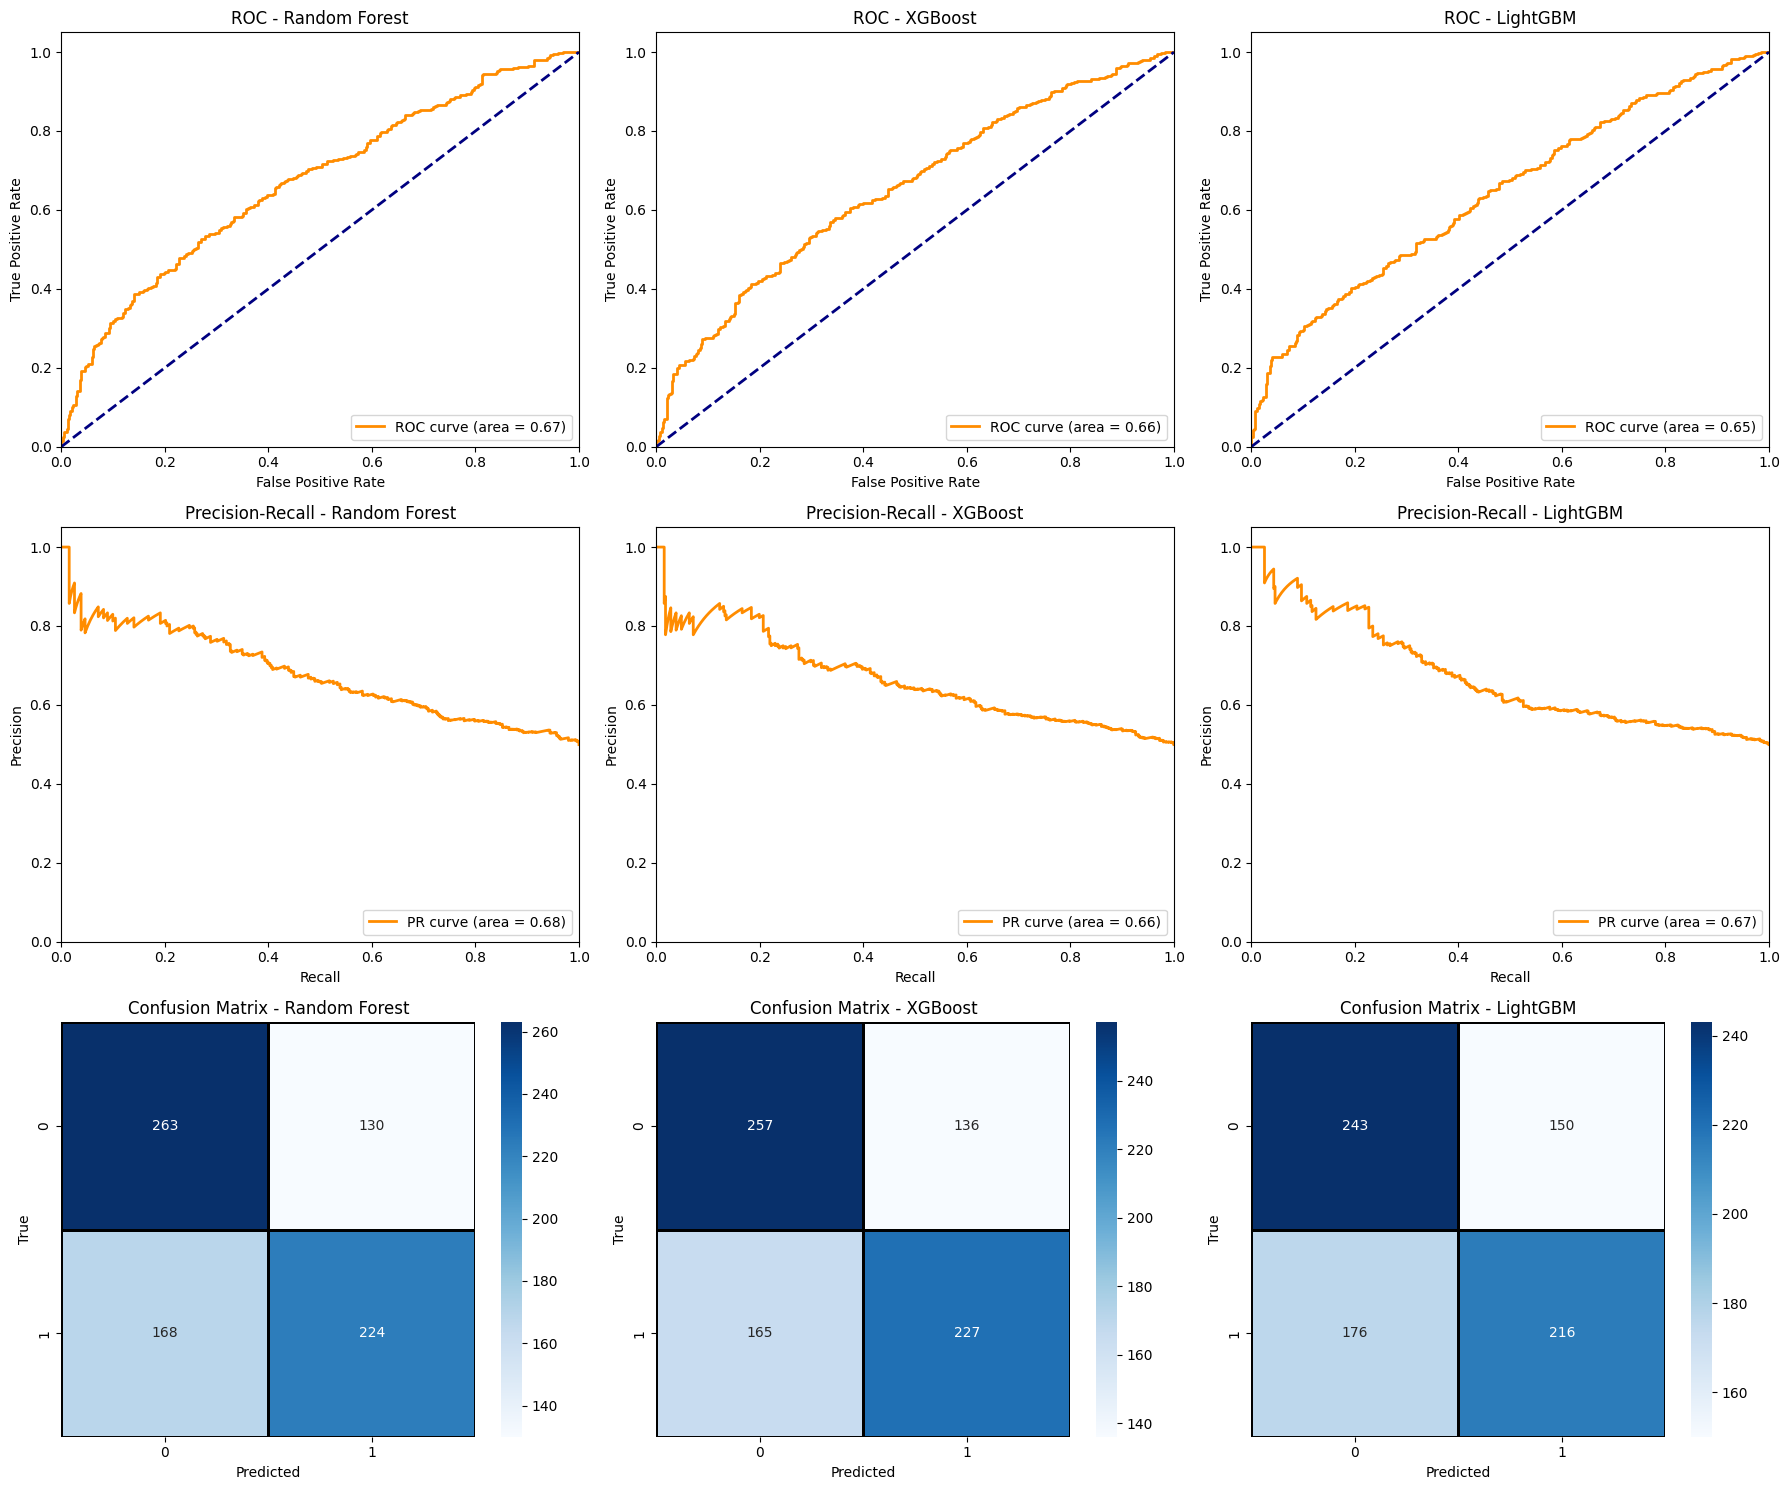

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.6203821656050955, 'Precision': 0.632768361581921, 'Recall': 0.5714285714285714, 'F1 Score': 0.6005361930294906, 'ROC AUC': 0.6699771511658098}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.6165605095541401, 'Precision': 0.6253443526170799, 'Recall': 0.5790816326530612, 'F1 Score': 0.6013245033112583, 'ROC AUC': 0.6562873240899413}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.5847133757961783, 'Precision': 0.5901639344262295, 'Recall': 0.5510204081632653, 'F1 Score': 0.5699208443271767, 'ROC AUC': 0.6450316767928546}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.5847133757961783,
 'Precision': 0.5901639344262295,
 'Recall': 0.5510204081632653,
 'F1 Score': 0.5699208443271767,
 'ROC AUC': 0.6450316767928546}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: Random Forest with Accuracy: 0.6204


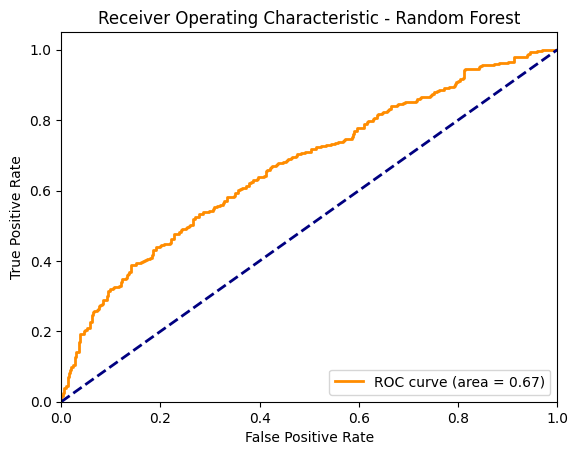

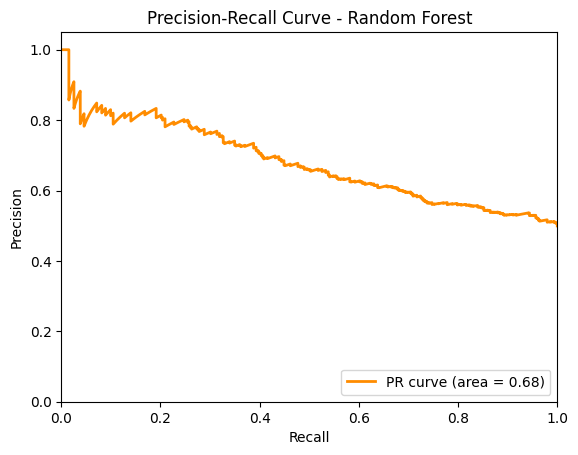

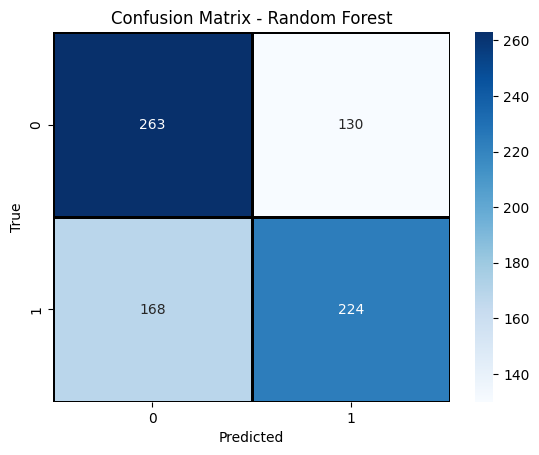

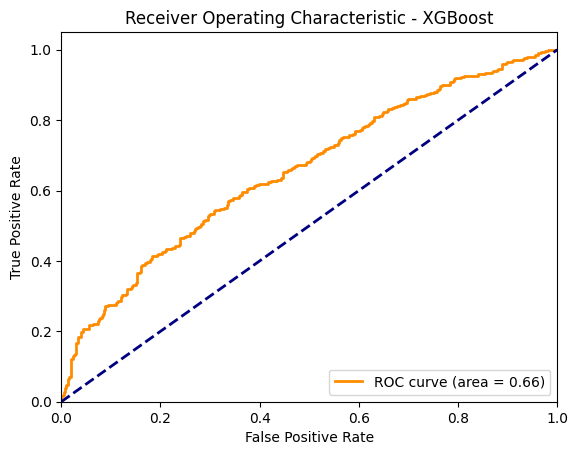

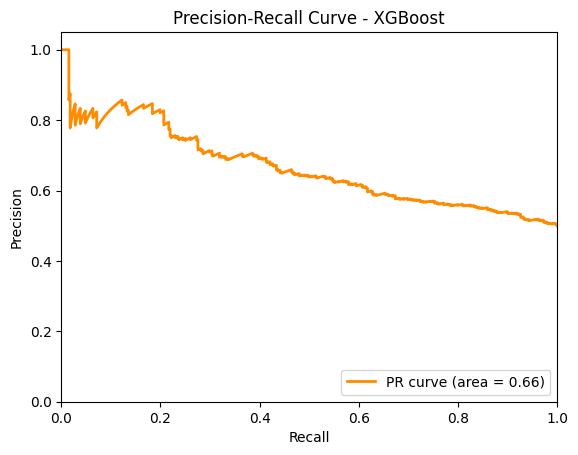

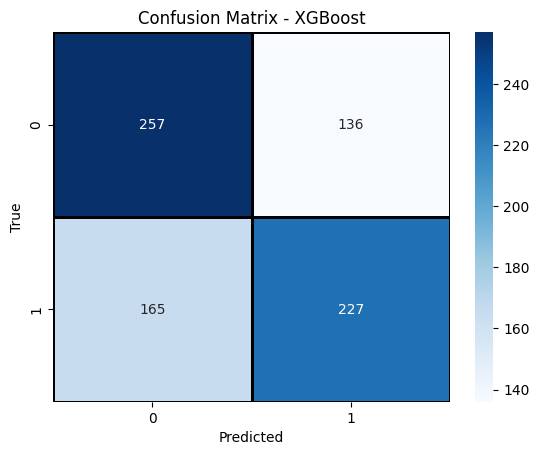

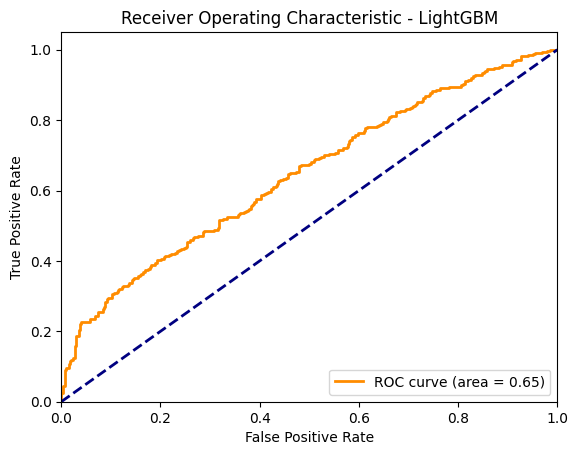

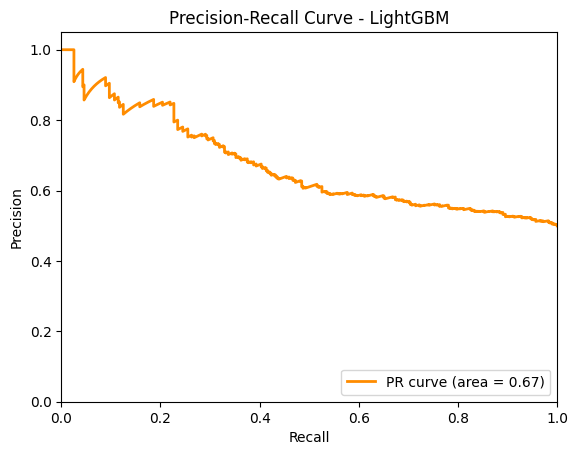

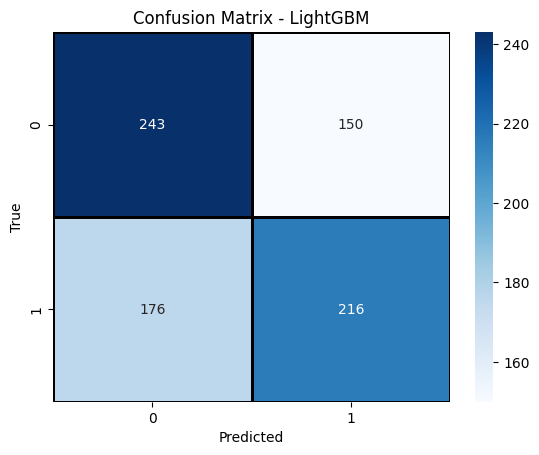

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

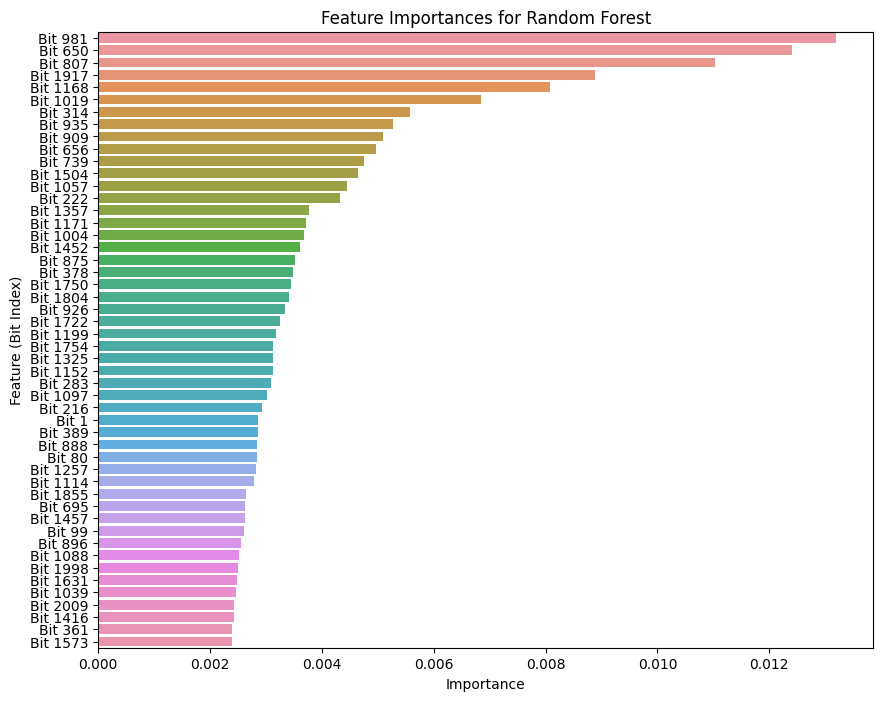

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
